In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor, as_completed

2024-05-08 16:48:11.284525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_path = './'

attack_types = {
    '0': 'Normal', '1': 'ConstPos', '2': 'ConstPosOffset', '3': 'RandomPos',
    '4': 'RandomPosOffset', '5': 'ConstSpeed', '6': 'ConstSpeedOffset',
    '7': 'RandomSpeed', '8': 'RandomSpeedOffset', '9': 'EventualStop',
    '10': 'Disruptive', '11': 'DataReplay', '12': 'DelayedMessages',
    '13': 'DoS', '14': 'DoSRandom', '15': 'DoSDisruptive',
    '16': 'GridSybil', '17': 'DataReplaySybil', '18': 'DoSRandomSybil',
    '19': 'DoSDisruptiveSybil'
}

def process_files(file_names):
    data_list = []
    sender_labels = {}
    for file_name in file_names:
        path = os.path.join(dataset_path, file_name)
        receiver_label = file_name.split('-')[1]
        try:
            attack_code = file_name.split('A')[1].split('-')[0]
            attack_label = attack_types.get(attack_code, 'Unknown')
        except IndexError:
            attack_label = 'Unknown'

        with open(path, 'r') as file:
            file_content = file.read().strip()
            entries = file_content.split('\n')
            for entry in entries:
                try:
                    json_data = json.loads(entry)
                    if json_data['type'] == 3:
                        json_data['receiver_label'] = receiver_label
                        json_data['attack_type'] = attack_label
                        data_list.append(json_data)
                        sender_id = json_data.get('sender')
                        if sender_id:
                            sender_labels[sender_id] = receiver_label
                except json.JSONDecodeError:
                    continue

    return data_list, sender_labels

files = [f for f in os.listdir(dataset_path) if f.endswith('.json')]
# Split files into chunks for batch processing
chunks = [files[i:i + 50] for i in range(0, len(files), 50)]


results = []
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(process_files, chunk): chunk for chunk in chunks}
    for future in as_completed(futures):
        results.append(future.result())

final_data_list = [item for sublist, _ in results for item in sublist]
all_sender_labels = {k: v for _, sl in results for k, v in sl.items()}

df = pd.DataFrame(final_data_list)
df['sender_label'] = df['sender'].map(all_sender_labels)

print("Dataset created and saved successfully.")

Dataset created and saved successfully.


In [3]:
df

,type,rcvTime,sendTime,sender,senderPseudo,messageID,pos,pos_noise,spd,spd_noise,acl,acl_noise,hed,hed_noise,receiver_label,attack_type,sender_label
0,3,66805.040609,66805.040609,110781,101107816,328888599,"[214.092218249178, 402.3433284448306, 0.0]","[4.791260166596812, 4.723747173989609, 0.0]","[-1.4735428488543287, 8.971846245466446, 0.0]","[0.0003830341997306996, -0.002332102030218812,...","[-0.3496841414347965, 2.1291828610465315, 0.0]","[8.732466105171294e-05, 0.0005386542086143764,...","[-0.011410482032727825, 0.9999348983307768, 0.0]","[20.991578295652264, 7.385971179035948, 0.0]",110985,Normal,110961
1,3,66805.193900,66805.193900,110709,101107096,328891386,"[212.3597877066629, 416.12908661626824, 0.0]","[4.498071808348472, 4.860074595117739, 0.0]","[-1.7208549522767238, 9.875550593644528, 0.0]","[0.0002485313569501767, -0.001426249303271485,...","[0.033917831976128514, -0.19457205670973024, 0.0]","[3.682282613838171e-05, 0.00013726285018726063...","[-0.005870134656625079, 0.9999827706111306, 0.0]","[22.65102440375612, 7.103335936070928, 0.0]",110985,Normal,110589
2,3,66805.205243,66805.205243,110979,101109796,328891675,"[265.46060904577564, 46.79675109533545, 0.0]","[4.576397321240698, 4.703359106402067, 0.0]","[-0.17933061770444234, 1.735397329390015, 0.0]","[0.00014561775338529202, -0.001409145712882202...","[-0.2015675720946343, 1.9509658519588826, 0.0]","[0.0009576200373791102, 0.0005971434288883837,...","[-0.09919379879386662, 0.9950681334867688, 0.0]","[10.082107193941175, 8.32522025941973, 0.0]",110985,Normal,111351
3,3,66805.259591,66805.259591,110757,101107576,328893110,"[244.26957724643907, 218.56607962751767, 0.0]","[3.7337190539984895, 3.40943266443334, 0.0]","[6.716517053466503, -0.6012459283357173, 0.0]","[-0.011775389103435509, 0.0010545948950231659,...","[2.38439145532918, -0.21199990488944653, 0.0]","[0.0038260015806621216, 0.0015806363285510415,...","[0.986139766194449, -0.165916730711395, 0.0]","[7.427106431901198, 15.439244887758887, 0.0]",110985,Normal,110193
4,3,66805.300912,66805.300912,110835,101108356,328893474,"[240.7272400391495, 250.4781686664868, 0.0]","[3.9630660022861592, 3.9313100563065158, 0.0]","[-8.006038446152996, 7.2935495741873915, 0.0]","[-0.0013367516815200947, 0.008889646534705309,...","[0.06675964721383834, -0.4436600282984141, 0.0]","[2.3214266581753767e-06, 1.54379177033908e-05,...","[-0.14689912273182845, 0.9891514786627067, 0.0]","[0.3006040340829716, 0.06635053101692073, 0.0]",110985,Normal,111105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324616,3,67852.447030,67852.447030,114543,101145436,342968868,"[1034.8721117524628, 483.0696136002422, 0.0]","[3.212708154807679, 3.382903754754585, 0.0]","[-15.592647388604393, -5.328741873743469, 0.0]","[0.03848162008896055, 0.013154137001921086, 0.0]","[0.29632661555252704, 0.10208932279783331, 0.0]","[0.0004201133979471888, 0.0013978676206493831,...","[-0.9999835449928784, -0.005736701445599095, 0.0]","[67.92877629385923, 24.338737024640352, 0.0]",114525,Normal,114525
2324617,3,67852.447289,67852.447289,114687,101146876,342968973,"[885.4304544960789, 507.76317799076867, 0.0]","[3.8641328037675358, 4.102728994791388, 0.0]","[-5.769849941290181, 4.337790179033981, 0.0]","[-0.003808399286607005, 0.002863021288104117, ...","[-1.5006278667976352, 1.1284105722645177, 0.0]","[0.0009229701935601865, 0.0006164636038601271,...","[-0.7977545449750922, 0.6029823264172703, 0.0]","[3.232555271579721, 1.1764588102911844, 0.0]",114525,Normal,114525
2324618,3,67852.595902,67852.595902,114357,101143576,342971643,"[668.7391828746679, 358.0416647599385, 0.0]","[5.04863946533614, 4.8295170855833325, 0.0]","[-14.345094955325852, -4.92631993899008, 0.0]","[0.023744038319494353, 0.008160270858628966, 0.0]","[0.3771656956811609, 0.12974618716863634, 0.0]","[6.697520522571179e-05, 0.00014228487222299642...","[-0.9827533949363382, 0.18492096890591325, 0.0]","[65.90157537316651, 25.694702573253007, 0.0]",114525,Normal,114525
23246

In [5]:
df['attack_type'].value_counts()*100/df.shape[0]

attack_type
Normal                70.559588
DoSDisruptive          1.711849
RandomSpeed            1.670036
Disruptive             1.661862
DataReplaySybil        1.646935
DataReplay             1.608047
EventualStop           1.607187
RandomPosOffset        1.587485
RandomPos              1.566234
DelayedMessages        1.562362
GridSybil              1.560082
DoSRandom              1.559136
DoS                    1.547091
ConstSpeedOffset       1.539004
RandomSpeedOffset      1.523603
DoSRandomSybil         1.476886
DoSDisruptiveSybil     1.464583
ConstPos               1.432320
ConstPosOffset         1.410251
ConstSpeed             1.305460
Name: count, dtype: float64

We clearly see a strong disproportion between the classes : the class *Normal* makes up to 70% percent of the data, when the other classes make less than 2% each. <br>
A resampling may then be useful to get better results.

In [6]:
def expand_list_numpy(df, col, names):
    arr = np.array(df[col].tolist())
    if arr.shape[1] == len(names):
        for i, name in enumerate(names):
            df[name] = arr[:, i]
    else:
        raise ValueError("Column length mismatch")
    return df.drop(col, axis=1)

list_columns = {
    'pos': ['pos_x', 'pos_y', 'pos_z'],
    'pos_noise': ['pos_noise_x', 'pos_noise_y', 'pos_noise_z'],
    'spd': ['spd_x', 'spd_y', 'spd_z'],
    'spd_noise': ['spd_noise_x', 'spd_noise_y', 'spd_noise_z'],
    'acl': ['acl_x', 'acl_y', 'acl_z'],
    'acl_noise': ['acl_noise_x', 'acl_noise_y', 'acl_noise_z'],
    'hed': ['hed_x', 'hed_y', 'hed_z'],
    'hed_noise': ['hed_noise_x', 'hed_noise_y', 'hed_noise_z']
}

for col, names in list_columns.items():
    df = expand_list_numpy(df, col, names)

In [7]:
display(df[['acl_z', 'acl_noise_z', 'hed_z', 'hed_noise_z', 'pos_z', 'pos_noise_z', 'spd_z', 'spd_noise_z', 'type']])

,acl_z,acl_noise_z,hed_z,hed_noise_z,pos_z,pos_noise_z,spd_z,spd_noise_z,type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...
2324616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2324617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2324618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2324619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


We drop columns with null values, as well as the column *type*

In [8]:
df = df.drop(columns=['acl_z', 'acl_noise_z', 'hed_z', 'hed_noise_z', 'pos_z', 'pos_noise_z', 'spd_z', 'spd_noise_z', 'type'], axis=1).dropna().drop_duplicates()

In [9]:
df

,rcvTime,sendTime,sender,senderPseudo,messageID,receiver_label,attack_type,sender_label,pos_x,pos_y,...,spd_noise_x,spd_noise_y,acl_x,acl_y,acl_noise_x,acl_noise_y,hed_x,hed_y,hed_noise_x,hed_noise_y
0,66805.040609,66805.040609,110781,101107816,328888599,110985,Normal,110961,214.092218,402.343328,...,0.000383,-0.002332,-0.349684,2.129183,0.000087,0.000539,-0.011410,0.999935,20.991578,7.385971
1,66805.193900,66805.193900,110709,101107096,328891386,110985,Normal,110589,212.359788,416.129087,...,0.000249,-0.001426,0.033918,-0.194572,0.000037,0.000137,-0.005870,0.999983,22.651024,7.103336
2,66805.205243,66805.205243,110979,101109796,328891675,110985,Normal,111351,265.460609,46.796751,...,0.000146,-0.001409,-0.201568,1.950966,0.000958,0.000597,-0.099194,0.995068,10.082107,8.325220
3,66805.259591,66805.259591,110757,101107576,328893110,110985,Normal,110193,244.269577,218.566080,...,-0.011775,0.001055,2.384391,-0.212000,0.003826,0.001581,0.986140,-0.165917,7.427106,15.439245
4,66805.300912,66805.300912,110835,101108356,328893474,110985,Normal,111105,240.727240,250.478169,...,-0.001337,0.008890,0.066760,-0.443660,0.000002,0.000015,-0.146899,0.989151,0.300604,0.066351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324616,67852.447030,67852.447030,114543,101145436,342968868,114525,Normal,114525,1034.872112,483.069614,...,0.038482,0.013154,0.296327,0.102089,0.000420,0.001398,-0.999984,-0.005737,67.928776,24.338737
2324617,67852.447289,67852.447289,114687,101146876,342968973,114525,Normal,114525,885.430454,507.763178,...,-0.003808,0.002863,-1.500628,1.128411,0.000923,0.000616,-0.797755,0.602982,3.232555,1.176459
2324618,67852.595902,67852.595902,114357,101143576,342971643,114525,Normal,114525,668.739183,358.041665,...,0.023744,0.008160,0.377166,0.129746,0.000067,0.000142,-0.982753,0.184921,65.901575,25.694703
2324619,67852.702925,67852.702925,114513,101145136,342972660,114525,Normal,114525,837.100358,424.578243,...,0.028040,0.011316,-4.171977,-1.683006,0.016759,0.005843,0.928436,0.371491,0.575392,0.879300


In [36]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

features = df.drop(columns=['attack_type'], axis=1)  

labels = df['attack_type']

features_numeric = features.select_dtypes(include=[np.number])

# Feature Normalization 
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_numeric), columns=features_numeric.columns)

Feature: sender Score: 0.2577868062812758
Feature: senderPseudo Score: 0.24374179790480355
Feature: hed_x Score: 0.10799260123773102
Feature: hed_y Score: 0.1070297203245989
Feature: hed_noise_x Score: 0.08326688640561208
Feature: hed_noise_y Score: 0.08277302118540852
Feature: messageID Score: 0.07710725637257809
Feature: sendTime Score: 0.0749531943706927
Feature: rcvTime Score: 0.07477065264554916
Feature: acl_y Score: 0.06987522524436685
Feature: acl_x Score: 0.06939033202037947
Feature: spd_y Score: 0.05983223055372022
Feature: spd_x Score: 0.05731105406917436
Feature: spd_noise_y Score: 0.043303794054304845
Feature: acl_noise_y Score: 0.04228999950227852
Feature: acl_noise_x Score: 0.0421952967838326
Feature: spd_noise_x Score: 0.042125319142012785
Feature: pos_noise_x Score: 0.037410741142901216
Feature: pos_noise_y Score: 0.03716256080817537
Feature: pos_y Score: 0.031444191210258765
Feature: pos_x Score: 0.02367731648554461


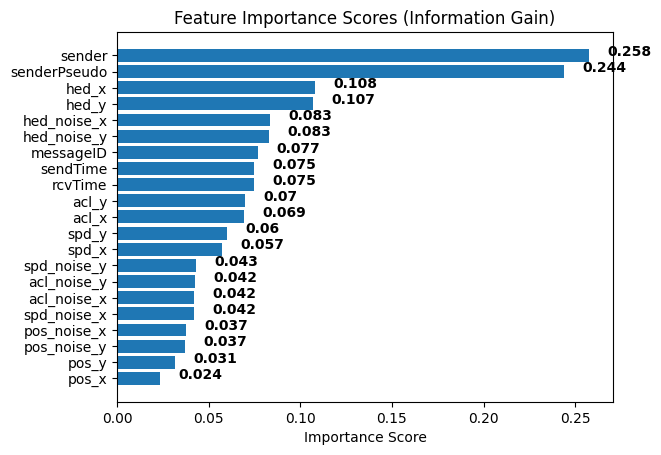

In [37]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X = features_scaled
y = labels
y_encoded = encoder.fit_transform(y)

ig = mutual_info_regression(X, y_encoded)

feature_scores = {}
for i, col in enumerate(X.columns):  
    feature_scores[col] = ig[i]

sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)

fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis() 
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

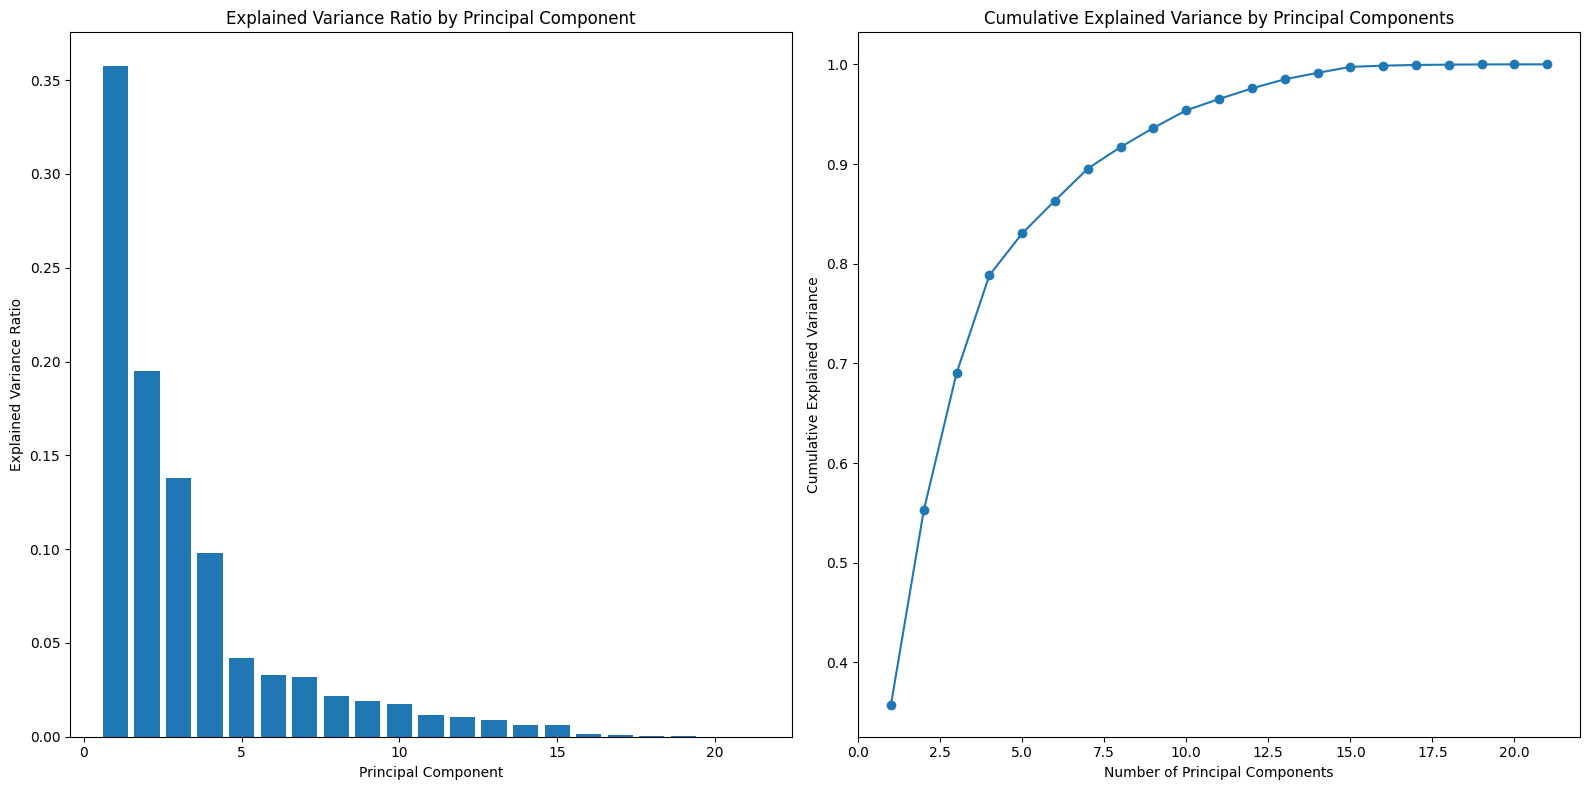

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = features_scaled
y = labels
feature_names = list(X.columns)

# Perform PCA
pca = PCA()
#X_pca = pca.fit_transform(X_scaled)
X_pca = pca.fit_transform(features_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

Nombre optimal de features d'après l'ACP : 17

In [39]:
pca_opt = PCA(n_components=17)  
#X_opt = pca_opt.fit_transform(X_scaled)
X_opt = pca_opt.fit_transform(features_scaled)

In [40]:
X_opt.shape

(2324621, 17)

## Training

In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels) 

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_opt, y_one_hot, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(features_for_train, y_one_hot, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Model architecture
model = Sequential([
    LSTM(128, input_shape=(17, 1), return_sequences=True),  
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')  # Output layer for 20 classes
])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'f1_score'])

In [46]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 17, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,428 (474.33 KB)

 Trainable params: 121,428 (474.33 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    LSTM(256, input_shape=(17, 1), return_sequences=True),  
    Dropout(0.3),
    LSTM(128, return_sequences=False),  
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax')  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop])

Epoch 1/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 1483s 203ms/step - AUC: 0.8475 - accuracy: 0.7048 - loss: 1.4914 - val_AUC: 0.8616 - val_accuracy: 0.7053 - val_loss: 1.4645 - learning_rate: 0.0010
Epoch 2/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 1601s 220ms/step - AUC: 0.8691 - accuracy: 0.7059 - loss: 1.4552 - val_AUC: 0.8967 - val_accuracy: 0.7053 - val_loss: 1.4110 - learning_rate: 0.0010
Epoch 3/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 2388s 329ms/step - AUC: 0.8999 - accuracy: 0.7053 - loss: 1.4032 - val_AUC: 0.9185 - val_accuracy: 0.7053 - val_loss: 1.3503 - learning_rate: 0.0010
Epoch 4/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 1767s 243ms/step - AUC: 0.9173 - accuracy: 0.7064 - loss: 1.3503 - val_AUC: 0.9307 - val_accuracy: 0.7053 - val_loss: 1.3050 - learning_rate: 0.0010
Epoch 5/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 1885s 259ms/step - AUC: 0.9256 - accuracy: 0.7059 - loss: 1.3208 - val_AUC: 0.9331 - val_accuracy: 0.7053 - val_loss: 1.2911 - learning_rate: 0.0010
Epoch 6/10
7265/7265 ━━━━━━━━━━━━━━━━━━━━ 161

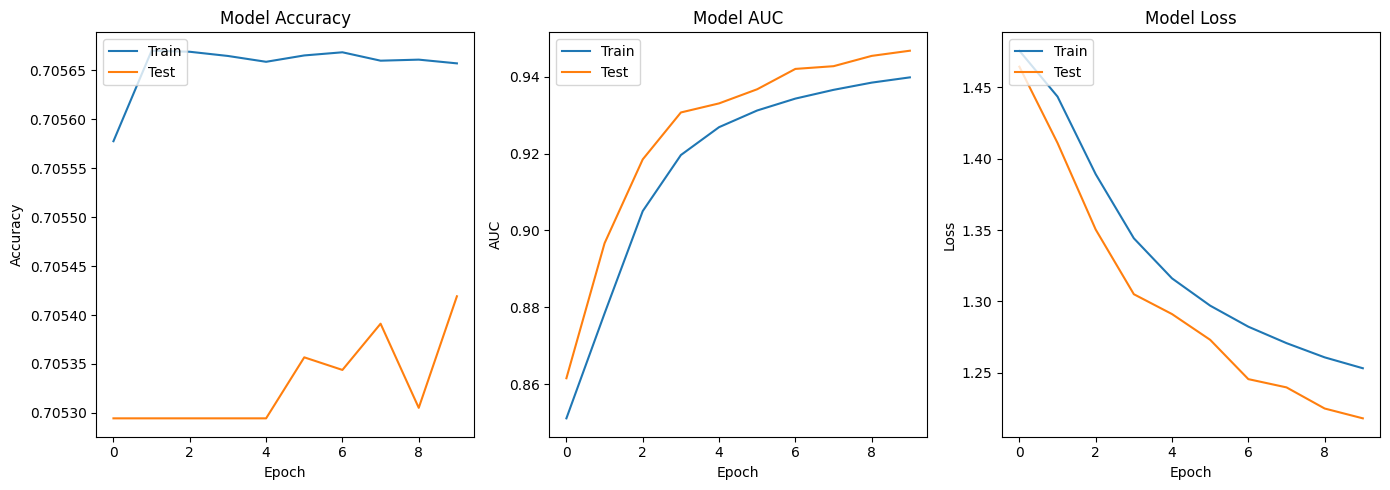

In [58]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 5))

# Subplot for accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Subplot for AUC
plt.subplot(1, 3, 2)
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Subplot for loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Evaluation metrics
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

14529/14529 ━━━━━━━━━━━━━━━━━━━━ 241s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

                    precision    recall  f1-score   support

          ConstPos       0.08      0.00      0.00      6750
    ConstPosOffset       0.00      0.00      0.00      6607
        ConstSpeed       0.00      0.00      0.00      6088
  ConstSpeedOffset       0.00      0.00      0.00      7122
        DataReplay       0.00      0.00      0.00      7422
   DataReplaySybil       0.00      0.00      0.00      7734
   DelayedMessages       0.00      0.00      0.00      7219
        Disruptive       0.00      0.00      0.00      7640
               DoS       0.00      0.00      0.00      7100
     DoSDisruptive       0.00      0.00      0.00      7968
DoSDisruptiveSybil       0.00      0.00      0.00      6830
         DoSRandom       0.00      0.00      0.00      7250
    DoSRandomSybil       0.00      0.00      0.00      6797
      EventualStop       0.90      0.01      0.02      7579
         GridSybil       0.00      0.00      0.00      7321
            Normal       0.71      1.00

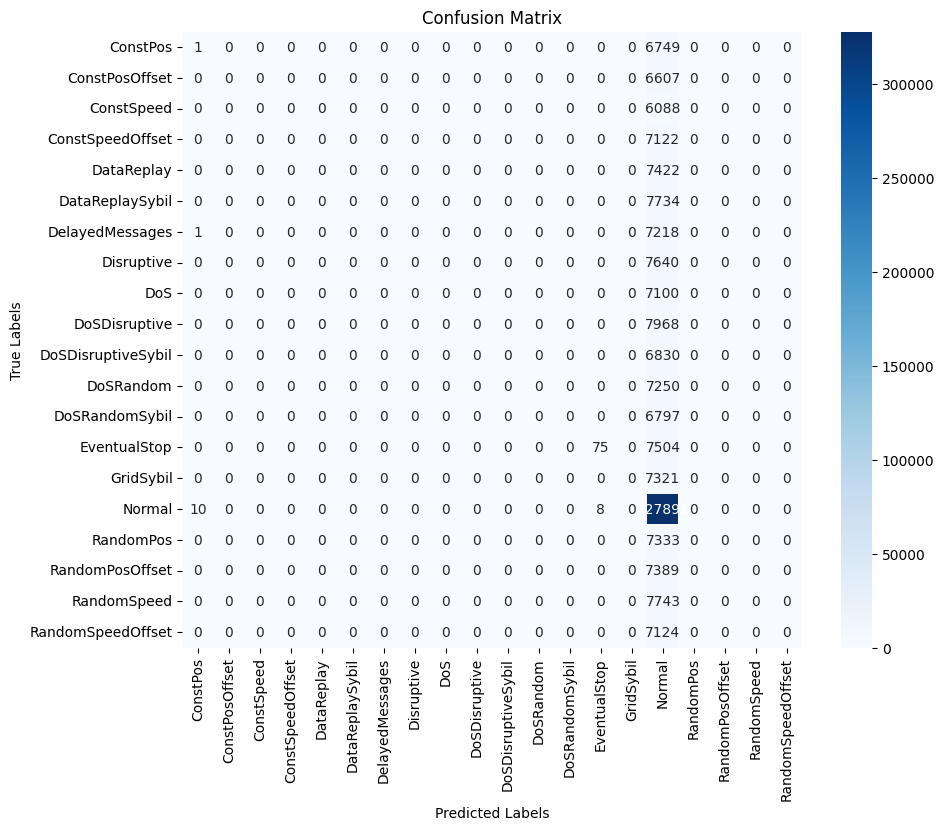

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using seaborn to create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()